<a href="https://colab.research.google.com/github/avimuk/AMLMasters/blob/main/AMLProgrammingAssignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Models For Classification

In this notebook we look at how to implement linear models in python.

The following datasets will be used for analysis -

1. [Bikeshare](https://drive.google.com/file/d/1mzUgrPg3Dndy-DFy8rf6Dqh6-jX1FaSe/view?usp=sharing)
2. [Stock-Market](https://drive.google.com/file/d/1bFNQ0DzvFAbNKa5G8PA-aLRo35xSYSBC/view?usp=sharing)


From before we use the 

1. `numpy` library for dealing with numerical datasets
2. `pandas` is used to manipilate the datasets using the DataFrame object.
3. `matplotlib` is used to plot the figures.
4. Use `sklearn` to implement logistic regression


In [74]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/"
HOUSING_URL = DOWNLOAD_ROOT + "Notebooks/Data/Smarket.csv"

def fetch_data(housing_url=HOUSING_URL):
    urllib.request.urlretrieve(housing_url, "/content/Smarket.csv")

fetch_data()

In [75]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
HOUSING_PATH="/content/Smarket.csv"
def load_housing_data(housing_path=HOUSING_PATH):
  return pd.read_csv(housing_path, index_col=0)

In [76]:
#Explore the dataset
data = load_housing_data()
print(data.head())
print()
data.describe()
print()
data.info()
print()
data["Direction"].value_counts()


   Year   Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today Direction
1  2001  0.381 -0.192 -2.624 -1.055  5.010  1.1913  0.959        Up
2  2001  0.959  0.381 -0.192 -2.624 -1.055  1.2965  1.032        Up
3  2001  1.032  0.959  0.381 -0.192 -2.624  1.4112 -0.623      Down
4  2001 -0.623  1.032  0.959  0.381 -0.192  1.2760  0.614        Up
5  2001  0.614 -0.623  1.032  0.959  0.381  1.2057  0.213        Up


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250 entries, 1 to 1250
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1250 non-null   int64  
 1   Lag1       1250 non-null   float64
 2   Lag2       1250 non-null   float64
 3   Lag3       1250 non-null   float64
 4   Lag4       1250 non-null   float64
 5   Lag5       1250 non-null   float64
 6   Volume     1250 non-null   float64
 7   Today      1250 non-null   float64
 8   Direction  1250 non-null   object 
dtypes: float64(7), int64(1), object(1)
memo

Up      648
Down    602
Name: Direction, dtype: int64

Saving figure Smarket_histogram_plots


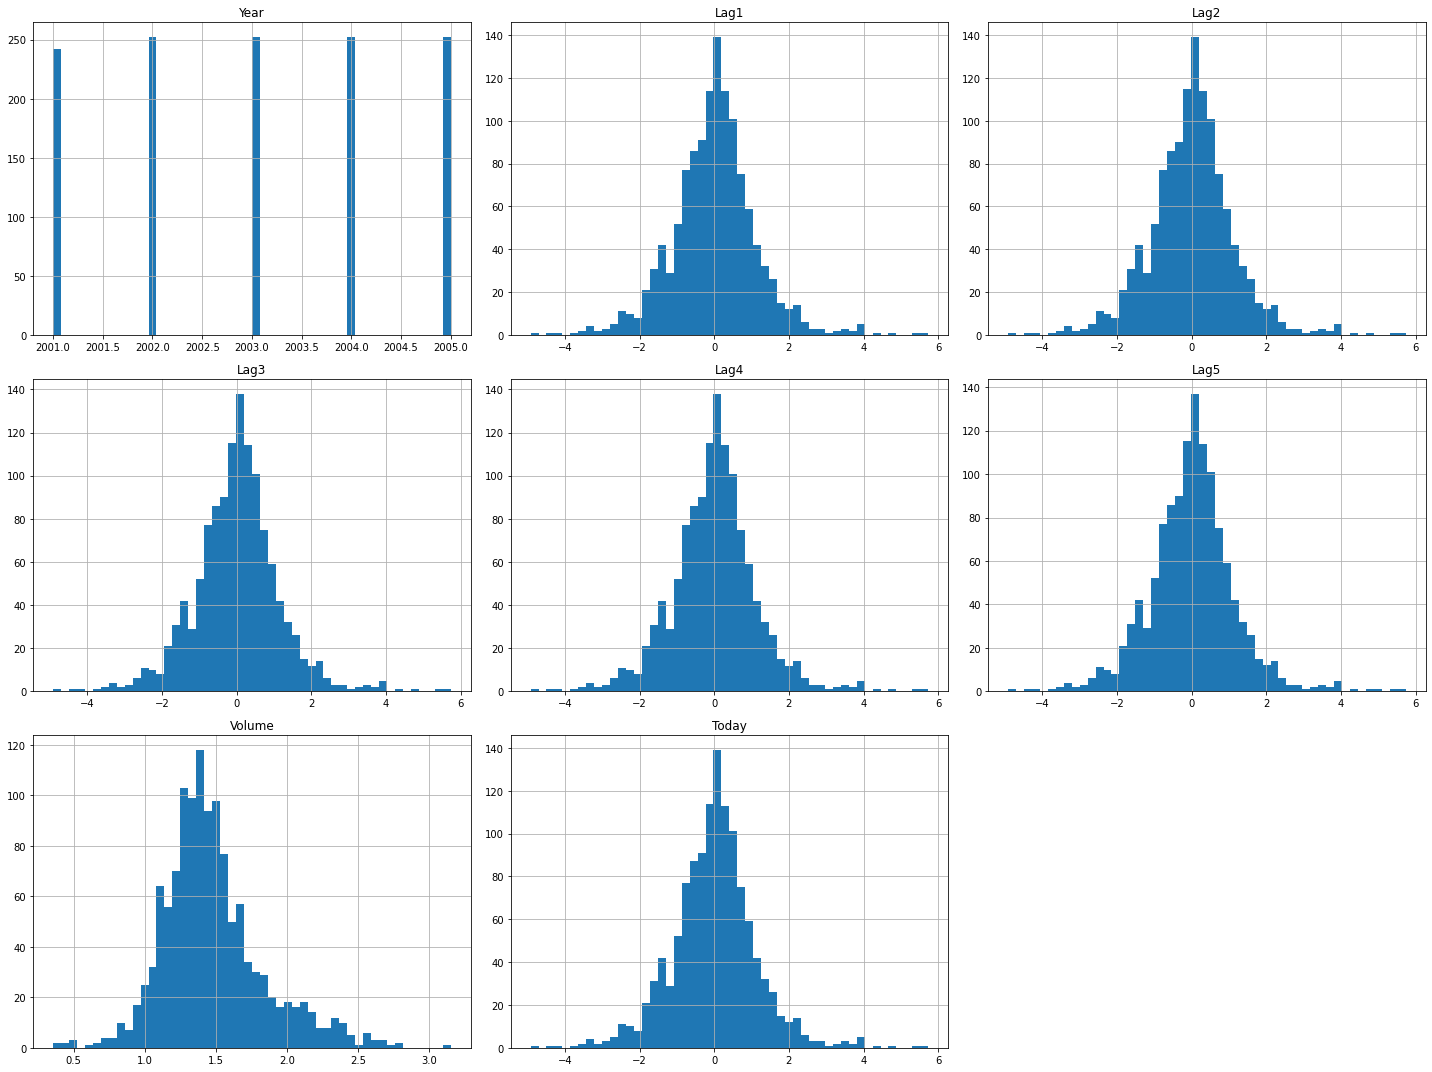

In [77]:
# Visualize the dataset
%matplotlib inline
import matplotlib.pyplot as plt
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Assignment1_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
data.hist(bins=50, figsize=(20,15))
save_fig("Smarket_histogram_plots")
plt.show()

First lets look at the stock market data. The aim is to predict the `Direction` variable using `lag_*` and `Volume` variables.

Before any analysis can be done we need to prepare the data by -

1. Encoding the output/response Up/Down as 0/1.
2. We then remove the `Year`, `Today` and `Direction` to get our independent variables.
3. Note that the sign of `Today` essentially dictates the Up/Down direction.

Question 1 : Write a function which takes a pandas dataframe, and column name and returns the mean, stdev, 25th Quantile, Median, 75th Quantile.

**IMPORTANT NOTE**: The function you have written should pass the test. Only those which have passed will be considered for grades. An example is shown below. 

In [78]:
def column_stats(data, col_name):
  """
  This function takes a dataframe and column name as input and returns required column stats
  """
  stats = data[col_name].describe()
  mean=stats["mean"]
  stdev=stats["std"]
  Q1=stats["25%"]
  median=stats["50%"]
  Q3=stats["75%"]
  return mean,stdev,Q1,median,Q3
 

def test_column_stats():
  """
  """
  data = pd.read_csv("/content/Smarket.csv", index_col=0)
  mean, stdev, Q1, median, Q3 = column_stats(data, 'Lag2')
  #print(mean)
  assert np.abs(mean - 0.003834) < 1e-4
  assert np.abs(stdev-1.136299) < 1e-4
  assert np.abs(Q1 - -0.639500) < 1e-4
  assert np.abs(median-0.039000) < 1e-4
  assert np.abs(Q3-0.596750) < 1e-4
  print("Testcase")
  print("-------------------")
  print("Success ! All the testcases of ColumnStats passed")

test_column_stats()

Testcase
-------------------
Success ! All the testcases of ColumnStats passed


Question 2: Split the dataset into train and test with sizes 998, 252 respectively.  Then fit a logistic regression model on this dataset.

Report the following:

1. Train Accuracy
2. Test Accuracy
3. `coef_` attribute
4. `intercept_` attribute.

Make sure the output is just the above quantities and nothing else.

**IMPORTANT NOTE 1:** Do not shuffle the dataset while splitting. The first 998 rows should be taken as train and remaining 252 should be taken as test.

**IMPORTANT NOTE 2:** Do not use the `Year` and `Today` for prediction.

**IMPORTANT NOTE 3:** Consider `Up` to be class 1 and `Down` to be class 0.

** Grading will be done on whether the test `test_classifier` function worked or not.


In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn import preprocessing

"""
Data Prep
"""
df = data.drop(["Year","Today","Direction"], axis=1)
df['Output'] = data['Direction']

#print(data['output'].unique())
#label_mapping = {"Up": 1, "Down": 0}
#df = df.replace({"output": label_mapping})
#print(df[-10:])


direction_encoder = preprocessing.LabelEncoder()
direction_encoder.fit(df['Output'])
df['Output'] = direction_encoder.transform(df['Output'])
#print("Before Encoding:", list(data['Direction'][-10:]))
#print("After Encoding:", df['Output'][-10:])
#print("The inverse from the encoding result:", direction_encoder.inverse_transform(df['Output'][-10:]))


def get_LR_classifier():

  #Target
  y = df['Output']

  #Features
  X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4','Lag5','Volume']]

  # Split the dataset
  XTrain,XTest,yTrain,yTest=train_test_split(X,y,train_size = 998,test_size=252, shuffle=False)

  # Train the model
  clf =  LogisticRegression() 
  clf.fit(XTrain,yTrain)

  # Reporting & Analysis
  print("Report")
  print("-------------------")
  print("Train Accuracy:")
  print(clf.score(XTrain, yTrain))
  print()
  print("Test Accuracy:")
  print(clf.score(XTest, yTest))
  print()
  print("coef_ attribute:")
  print(np.array(clf.coef_))
  print()
  print("intercept_ attribute:")
  print(clf.intercept_)
  print()
  print("[Optional]Confusion Matrix:")
  yPred=clf.predict(XTest) 
  cnf_matrix = metrics.confusion_matrix(yTest, yPred) 
  print(cnf_matrix)

  return clf, XTrain, yTrain, XTest, yTest

#get_LR_classifier()

def test_LR_classifier():
  clf, XTrain, yTrain, XTest, yTest = get_LR_classifier()
  assert np.abs(clf.score(XTrain, yTrain) - 0.5250501002004008) < 1e-4
  assert np.abs(clf.score(XTest, yTest) - 0.48412698412698413) < 1e-4
  arr = np.array([[-0.05410202, -0.04559333,  0.00727805,  0.00653897, -0.00415829, -0.10995391]])
  assert np.sum(np.abs(np.array(clf.coef_) - arr)) <6*1e-4
  assert np.abs(clf.intercept_ - 0.18259423) < 1e-4
  print()
  print("Testcase")
  print("-------------------")
  print("Success ! All the testcases of LogisticRegression passed")
test_LR_classifier()



Report
-------------------
Train Accuracy:
0.5250501002004008

Test Accuracy:
0.48412698412698413

coef_ attribute:
[[-0.05410202 -0.04559333  0.00727805  0.00653897 -0.00415829 -0.10995391]]

intercept_ attribute:
[0.18259423]

[Optional]Confusion Matrix:
[[74 37]
 [93 48]]

Testcase
-------------------
Success ! All the testcases of LogisticRegression passed


Question 3: Using the sklearn package `from sklearn.naive_bayes.GaussianNB` fit a naive bayes classifier. Use only the features `Lag2` and `Lag3` for this purpose.

eport the following quantities from the properties of the classifier:

1. `class_prior_`
2. `theta_`
3. `var_`
4. Confusion Matrix for the test data.

**IMPORTANT NOTE** The above quantities should be printed with correct labelling. 


In [80]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

df = data.drop(["Year","Today","Direction"], axis=1)
df['Output'] = data['Direction']

direction_encoder = preprocessing.LabelEncoder()
direction_encoder.fit(df['Output'])
df['Output'] = direction_encoder.transform(df['Output'])

def get_NB_classifier():
  #Target
  y = df['Output']

  #Features
  X = df[['Lag2','Lag3']]

  #Split the dataset
  XTrain,XTest,yTrain,yTest=train_test_split(X,y,train_size = 998,test_size=252, shuffle=False)

  #Train the model
  clf =  GaussianNB()
  clf.fit(XTrain,yTrain)

  # Reporting & Analysis
  print("Report")
  print("-------------------")
  print("class_prior_ attribute:")
  print(np.array(clf.class_prior_))
  print()
  print("theta_ attribute:")
  print(np.array(clf.theta_))
  print()
  print("var_ attribute:")
  print(np.array(np.sqrt(clf.var_)))
  print()
  print("Confusion Matrix:")
  yPred=clf.predict(XTest) 
  cnf_matrix = metrics.confusion_matrix(yTest, yPred) 
  print(cnf_matrix)

  return clf, XTrain, yTrain, XTest, yTest

def test_NB_classifier():
  clf, Xtrain, yTrain, XTest, yTest = get_NB_classifier()
  arr1 = np.array([0.49198397, 0.50801603])
  assert np.sum(np.abs(np.array(clf.class_prior_) - arr1)) < 2*1e-4

  arr2 = np.array([[ 0.03389409, -0.00980652],
                    [-0.03132544,  0.00583432]])
  assert np.sum(np.abs(np.array(clf.theta_) - arr2)) < 4*1e-4


  arr3 = np.array([[1.23792871, 1.23412176],
                   [1.21956089, 1.22963]])
  assert np.sum(np.abs(np.array(np.sqrt(clf.var_)) - arr3)) <6*1e-4

  arr4 = np.array([[  9, 102],
                   [  7, 134]])
  assert np.sum(np.abs(np.array(arr4) - arr4)) < 4*1e-4  

  print()
  print("Testcase")
  print("-------------------")
  print("Success ! All the testcases  of GaussianNB passed")

test_NB_classifier()  

Report
-------------------
class_prior_ attribute:
[0.49198397 0.50801603]

theta_ attribute:
[[ 0.03389409 -0.00980652]
 [-0.03132544  0.00583432]]

var_ attribute:
[[1.23792871 1.23412176]
 [1.21956089 1.22963   ]]

Confusion Matrix:
[[  9 102]
 [  7 134]]

Testcase
-------------------
Success ! All the testcases  of GaussianNB passed
